### Read through each step and run the code in order.




### 0 - Includes and Constants
    
Display original image in either BGR | RGB | HSV

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from copy import deepcopy

# Read the image
IMAGE_FILE = cv2.imread("cock.jpg")

# Parameters for the grid
rows = 5  # Number of rows of nodes
cols = 9  # Number of columns of nodes
node_radius = 5  # Radius of the nodes  


# Start and end position
start_position = [1, 1, "E"]
end_position = [4, 8]

### 1 - Crop Image

Use mouse to select cropped area, hit 's' to save the image. Hit 'esc' to exit.

Crop ON the edge or INSIDE the edge.

Image saved as 'cropped_maze.jpg'


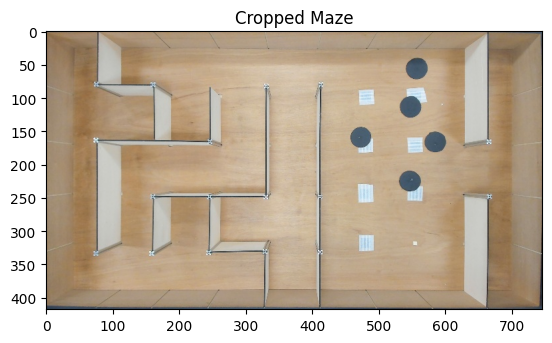

In [3]:
# Resize the image to half its original size
height, width = IMAGE_FILE.shape[:2]
original_image = cv2.resize(IMAGE_FILE, (width // 4, height // 4))

# Mouse callback function for selecting the crop area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False

# Create a window and set the mouse callback
cv2.namedWindow('Maze')
cv2.setMouseCallback('Maze', mouse_callback)

# Display the image
cv2.imshow('Maze', original_image)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the cropped image
        if start_point != end_point:
            # Get the region of interest
            roi = original_image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            # Save the cropped image
            cv2.imwrite('cropped_maze.jpg', roi)
            print("Image saved as 'cropped_maze.jpg'")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

# Load and display the cropped image using matplotlib
cropped_image = cv2.imread('cropped_maze.jpg')
if cropped_image is not None:
    # Convert BGR to RGB
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image_rgb)
    plt.title('Cropped Maze')
    plt.show()


### 2 - HSV Picker

Find the low and high HSV values in the selected area. 

DO NOT include any area with walls, standoffs or holes. 

Select 3 areas and hit 's' to record average low and high HSV values. Hit 'esc' to exit.

In [8]:
# Load the image
cropped_maze = cv2.imread("cropped_maze.jpg")

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False
regions = []  # List to store selected regions
MAX_AREAS = 3

# Function to calculate the minimum and maximum HSV values of a region
def calculate_hsv_values(img, start_point, end_point):
    # Ensure the start and end points are within the image bounds
    start_x, start_y = start_point
    end_x, end_y = end_point
    if start_x > end_x or start_y > end_y or start_x < 0 or start_y < 0 or end_x > img.shape[1] or end_y > img.shape[0]:
        print("Selected area is out of bounds.")
        return None, None

    # Get the region of interest
    roi = img[start_y:end_y, start_x:end_x]
    if roi.size == 0:
        print("Selected area is empty.")
        return None, None
    
    # Convert the region to HSV
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    min_hsv = np.min(hsv_roi.reshape(-1, 3), axis=0)
    max_hsv = np.max(hsv_roi.reshape(-1, 3), axis=0)
    
    return min_hsv, max_hsv

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, regions
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        if len(regions) >= MAX_AREAS:
            regions.pop(0)  # Remove the earliest area if the limit is exceeded
        regions.append((start_point, end_point))
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
        

# Create a window and set the mouse callback
cv2.namedWindow('Cropped Maze')
cv2.setMouseCallback('Cropped Maze', mouse_callback)

# Display the image
cv2.imshow('Cropped Maze', cropped_maze)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the HSV values
        if regions:
            all_min_hsv = []
            all_max_hsv = []
            for start_point, end_point in regions:
                min_hsv, max_hsv = calculate_hsv_values(cropped_maze, start_point, end_point)
                if min_hsv is not None and max_hsv is not None:
                    all_min_hsv.append(min_hsv)
                    all_max_hsv.append(max_hsv)
            
            if all_min_hsv and all_max_hsv:
                overall_min_hsv = np.round(np.min(all_min_hsv, axis=0), 2)
                overall_max_hsv = np.round(np.max(all_max_hsv, axis=0), 2)
                
                print(f"low_hsv = [{overall_min_hsv[0]}, {overall_min_hsv[1]}, {overall_min_hsv[2]}]")
                print(f"high_hsv = [{overall_max_hsv[0]}, {overall_max_hsv[1]}, {overall_max_hsv[2]}]")
            else:
                print("No valid regions selected.")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

low_hsv = [0, 0, 114]
high_hsv = [110, 142, 255]


### 3 - Create Mask based on HSV Values


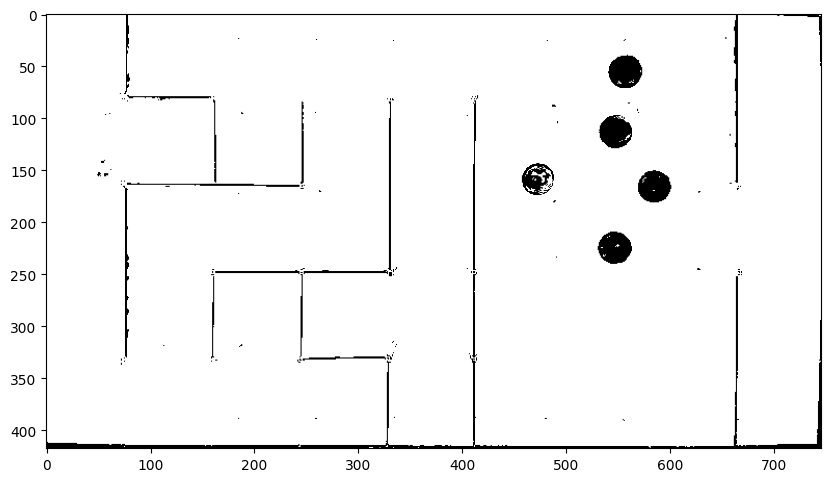

In [11]:
mask_adjust = -0

# BACKUP HSV VALUES
# TODO: USE THEM AS BACKUP!!!
# lower_backup = np.array([0, 0, 0])
# upper_backup = np.array([118, 46, 128])

# Load the image
image = cv2.imread("cropped_maze.jpg")
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create the mask 
mask = cv2.inRange(image_HSV, overall_min_hsv + mask_adjust, overall_max_hsv - mask_adjust)
# mask = cv2.inRange(image_HSV, lower_backup, upper_backup)
# mask = cv2.bitwise_not(mask)


# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.show()

### 4 - Image processing

Tune it using the four variables. 

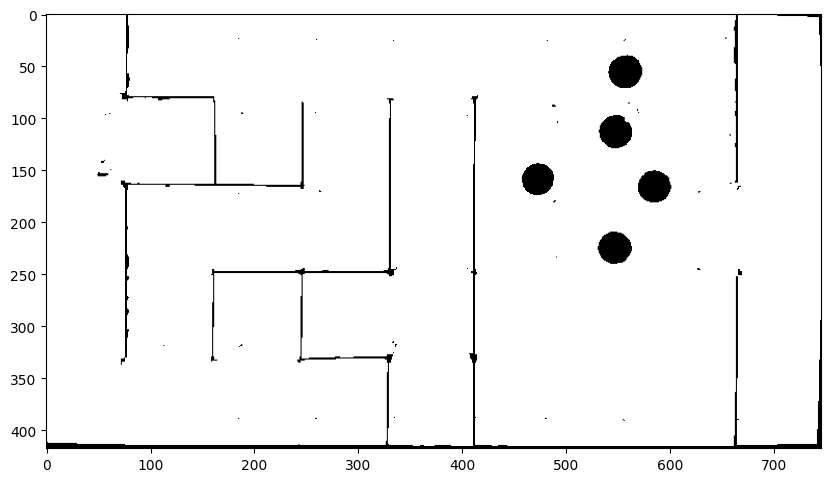

In [12]:
# Parameters for erosion and dilation
erosion_kernel_size = (3, 3)  # Size of the kernel for erosion
dilation_kernel_size = (3, 3)  # Size of the kernel for dilation
iterations_erosion = 2  # Number of erosion iterations
iterations_dilation = 2  # Number of dilation iterations

erosion_kernel = np.ones(erosion_kernel_size, np.uint8)
dilation_kernel = np.ones(dilation_kernel_size, np.uint8)

result = mask

# result = cv2.bitwise_not(mask)


# Perform erosion
result = cv2.erode(result, erosion_kernel, iterations=iterations_erosion)

# Perform dilation
result = cv2.dilate(result, dilation_kernel, iterations=iterations_dilation)

# Save the result image
cv2.imwrite('mask.jpg', result)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')
plt.show()


### 5 - Class for BFS

In [13]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        self.edges[node_id1] = [(nid, w) for nid, w in self.edges[node_id1] if nid != node_id2]
        self.edges[node_id2] = [(nid, w) for nid, w in self.edges[node_id2] if nid != node_id1]
    
    def remove_node(self, node_id):
        # Remove edges connected to the node
        if node_id in self.edges:
            for nid in self.edges[node_id]:
                self.remove_edge(node_id, nid[0])
            del self.edges[node_id]
        
        # Remove the node itself
        if node_id in self.nodes:
            del self.nodes[node_id]

            
    def get_nodes(self):
        return self.nodes.keys()
    
    def get_edge_weight(self, node_id1, node_id2):
        for nid, w in self.edges[node_id1]:
            if nid == node_id2:
                return w
        return None

### 6 - Grid Generation

Generate grid on the maze

Selected area: ((36, 39), (705, 378))


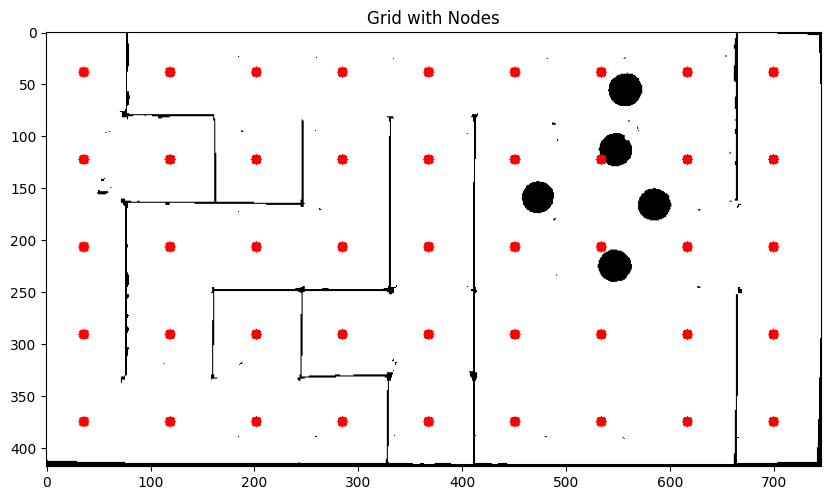

In [14]:
graph = Graph()

# Variable for path width
path_width = 3 

# Load the mask image (from the previous script)
result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
# mask = cv2.imread("mask_2.jpg")
# result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
# result = result_rgb.copy()

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()

    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    return grid_image, cell_width, cell_height

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, cell_width, cell_height = create_grid(result_rgb, selected_area, rows, cols)
    
    # Display the final grid image with nodes
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

## 7 - Define Entry and Exit node of Obstacle Area

Change prm_start_node and prm_end_node accordingly

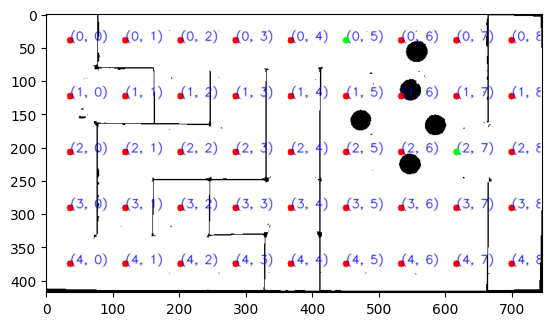

In [15]:
# SET START AND END NODES MANUALLY
prm_start_node = (0, 5)
prm_end_node = (2, 7)
prm_start_node_coords = graph.nodes[prm_start_node].get_point()
prm_end_node_coords = graph.nodes[prm_end_node].get_point()

# print out map with node numbers
node_select_image = grid_image.copy()
for nodeId in graph.get_nodes():
    x, y = graph.nodes[nodeId].get_point()
    cv2.putText(node_select_image, str(nodeId), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, cv2.LINE_AA)

cv2.circle(node_select_image, prm_start_node_coords, 5, (0, 255, 0), -1)
cv2.circle(node_select_image, prm_end_node_coords, 5, (0, 255, 0), -1)

plt.imshow(node_select_image)
plt.show()

## 8 Generate Unsafe Zone around Obstacles

Select area of the obstacle zone WITHIN the walls

Selected area: ((427, 16), (653, 281))


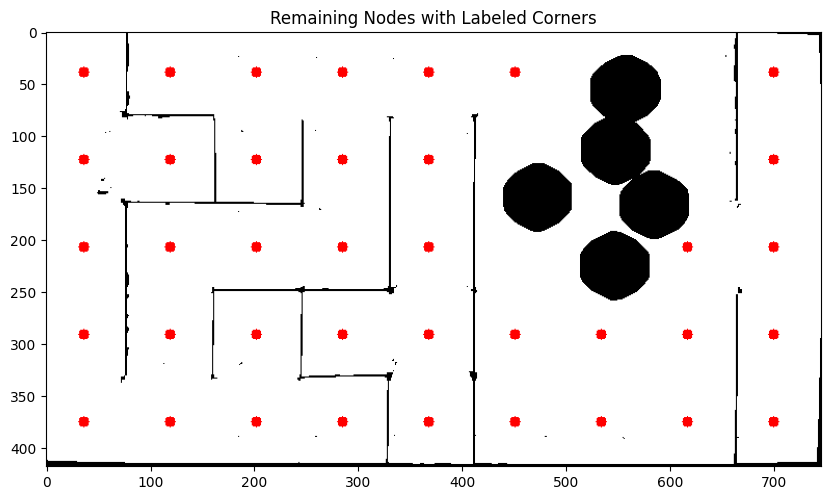

In [18]:
dilation_iteration = 6


# Function to handle mouse callback for selecting area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = grid_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the grid image for selecting area
cv2.imshow('Select Grid Area', grid_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

(start_x, start_y), (end_x, end_y) = selected_area

# Remove nodes within the selected area
removedNodeIds = []
for node in graph.nodes.values():
    x, y = node.get_point()
    # print('ecks, why = ', x, y)
    if (start_x <= x <= end_x and start_y <= y <= end_y):
        if (x, y) != prm_start_node_coords and (x, y) != prm_end_node_coords:
            removedNodeIds.append(node.get_ID())

for nodeId in removedNodeIds:
    graph.remove_node(nodeId)

result_marked = result_rgb.copy()

# expand obstacles in range
section = result_marked[start_y:end_y, start_x:end_x]
    
kernelOpening = np.ones((3, 3), np.uint8)
# kernel = np.ones((7, 7), np.uint8) 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)) # Changed kernel from square to circular 
sectionEroded = cv2.dilate(src=section, kernel=kernelOpening, iterations=3)
sectionEroded = cv2.erode(src=sectionEroded, kernel=kernelOpening, iterations=3)
sectionEroded = cv2.erode(src=sectionEroded, kernel=kernel, iterations=dilation_iteration)

sectionR = section.copy()
sectionR[:, :, 0] = 0
sectionR[:, :, 1] = 0
sectionR[:, :, 2] = 0
section = cv2.bitwise_or(sectionEroded, sectionR)

# join images together
result_marked[start_y:end_y, start_x:end_x] = section


# Create a copy of the original result image
result_with_nodes = result_marked.copy()

# Draw the remaining nodes on the result image
for nodeId in graph.get_nodes():
    x, y = graph.nodes[nodeId].get_point()
    cv2.circle(result_with_nodes, (x, y), 5, (255, 0, 0), -1)

# Display the result image with the remaining nodes and labeled corners
plt.figure(figsize=(10, 10))
plt.imshow(result_with_nodes)
plt.title('Remaining Nodes with Labeled Corners')
plt.show()

## 9 PRM

Generate nodes and edges using PRM for obstacle area

Start node closest nodes: [(82, 7.211102550927978), (21, 8.06225774829855), (208, 8.06225774829855), (237, 8.54400374531753), (203, 8.94427190999916)]
End node closest nodes: [(182, 6.082762530298219), (279, 9.0), (295, 10.0), (196, 11.313708498984761), (87, 12.36931687685298)]


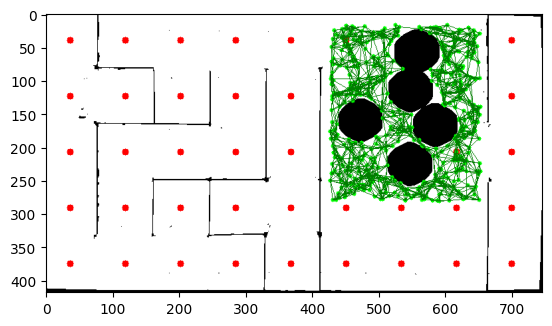

In [21]:
## PRM IMPLEMENTATION
import random
import math
import skimage
seed = 40
iterations = 500
k_connections = 5
max_connection_range = 70
prm_image = result_with_nodes.copy()
prm_graph = Graph()
random.seed(seed)

def path_clear(image, x1, y1, x2, y2):
    rgbMax = 255
    from skimage.draw import line
    rr, cc = line(x1, y1, x2, y2)
    testLine = list(zip(rr,cc))

    for pixel in testLine:
        pixelX, pixelY = pixel
        r, g, b = image[pixelX, pixelY]

        # Check if the pixel is neither white (255, 255, 255) nor red (255, 0, 0)
        if not ((r == 255 and g == 255 and b == 255) or  # White
                (r == 255 and g == 0 and b == 0)):       # Red
            return False
    
        # for channel in image[pixelX, pixelY]:
        #     if channel != rgbMax:
        #         return False
    return True

# def path_clear(rgb_image, x1, y1, x2, y2):
#     # Define the white color in RGB
#     white = [255, 255, 255]
    
#     # Draw the line on a blank image to get all line pixels
#     line_img = np.zeros_like(rgb_image)
#     cv2.line(line_img, (x1, y1), (x2, y2), color = (white[0], white[1], white[2]), thickness = 1)

#     # Extract coordinates of the line pixels
#     line_points = np.nonzero(line_img[:, :, 0])  # We only need the first channel for non-zero points
#     line_coords = list(zip(line_points[0], line_points[1]))
    
#     # Check if all the points along the line are white in the original image
#     for y, x in line_coords:
#         if not np.all(rgb_image[y, x] == white):
#             return False

#     return True



def find_closest_nodes(image, graph, target_x, target_y, n, range):
        # nodes is a list of tuples (int node_id, double distance)
        nodes = []
        # loop through the whole graph and grab nodes within range. Sort and return n closest.
        for node in graph.get_nodes():
            nodeX, nodeY = graph.nodes[node].get_point()
            distance = math.sqrt((target_x - nodeX) ** 2 + (target_y - nodeY) ** 2)
            # if distance <= range and distance != 0.0 and path_clear(image, nodeX, nodeY, target_x, target_y):
            if distance <= range and distance != 0.0:
                if path_clear(image, nodeX, nodeY, target_x, target_y):
                    nodes.append((graph.nodes[node].get_ID(), distance))
        
        closestNodes = sorted(nodes, key=lambda node: node[1])
        return closestNodes[:n]

(start_x, start_y), (end_x, end_y) = selected_area
i = 0
while i < iterations:
    x = random.randint(start_x, end_x)
    y = random.randint(start_y, end_y)

    # my own coordinates are reversed from the provided ones, so swap them
    x, y = y, x

    # check if node is in free space - if colliding with an obstacle, skip this iteration
    nodeCollision = False
    for channel in prm_image[x, y]:
        if channel != 255:
            nodeCollision = True
    if nodeCollision:
        continue

    # if all good, then add this node with iteration count as id to the graph.
    prm_graph.add_node(i, x, y)

    # draw straight lines to n closest nodes. If path clear, add edge to graph.
    # find_closest_nodes guarantees that the paths returned are all clear, so no need to recheck.
    closestNodes = find_closest_nodes(prm_image, prm_graph, x, y, k_connections, max_connection_range)
    # print(closestNodes)
    for node in closestNodes:
        nodeId, nodeDist = node
        nodeX, nodeY = prm_graph.nodes[nodeId].get_point()
        # 'i' is id of searching node, 'nodeId' is id of found node. 
        prm_graph.add_edge(i, nodeId, nodeDist)
    i += 1
# plt.imshow(prm_image)
# plt.show()

# add start node
prm_graph.add_node(-1, prm_start_node_coords[1], prm_start_node_coords[0])
closestNodes = find_closest_nodes(prm_image, prm_graph, prm_start_node_coords[1], prm_start_node_coords[0], k_connections, max_connection_range)
print(f"Start node closest nodes: {closestNodes}")
for node in closestNodes:
    nodeId, nodeDist = node
    nodeX, nodeY = prm_graph.nodes[nodeId].get_point()
    prm_graph.add_edge(-1, nodeId, nodeDist)

# add end node
prm_graph.add_node(-2, prm_end_node_coords[1], prm_end_node_coords[0])
closestNodes = find_closest_nodes(prm_image, prm_graph, prm_end_node_coords[1], prm_end_node_coords[0], k_connections, max_connection_range)
print(f"End node closest nodes: {closestNodes}")
for node in closestNodes:
    nodeId, nodeDist = node
    nodeX, nodeY = prm_graph.nodes[nodeId].get_point()
    prm_graph.add_edge(-2, nodeId, nodeDist)


# draw all nodes and edges on image
for node in prm_graph.get_nodes():
    x, y = prm_graph.nodes[node].get_point()
    id = node
    cv2.circle(prm_image, (y, x), 3, (0, 255, 0), -1)

for edgeStart in prm_graph.edges.keys():
    # print(edgeStart, ': ', prm_graph.edges[edgeStart])
    startX, startY = prm_graph.nodes[edgeStart].get_point()

    for edge in prm_graph.edges[edgeStart]:
        edgeEnd, dist = edge
        endX, endY = prm_graph.nodes[edgeEnd].get_point()
        cv2.line(prm_image, (startY, startX), (endY, endX), (0, 125, 0), 1)

# Display resulting image
plt.imshow(prm_image)
plt.show()

## 10 Run Dijkstra

Find the shortest path between obstacle area entry and exit

Path: [-1, 208, 88, 97, 12, 31, 95, 105, 224, 403, 217, 182, -2], Cost: 264.0122246801173


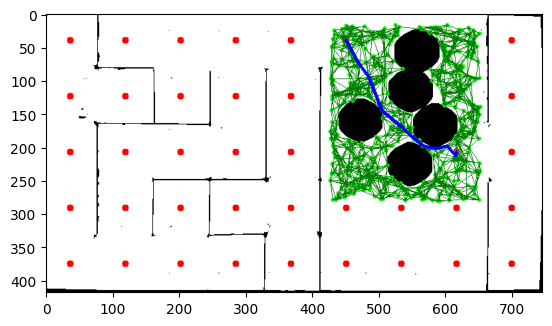

r60f24r3f20l2f75l8f75r15f164l28f113r3f57l2f74l28f58l25f52r62f59l129f18r80 


In [22]:
class PriorityQueue:
    def __init__(self):
        self.queue = {}
    
    def isEmpty(self):
        return len(self.queue.keys()) == 0
    
    def push(self, nodeId, distance):
        self.queue[nodeId] = distance
    
    # returns the tuple in the queue with the lowest distance
    def pop(self):
        if self.isEmpty():
            return None
        
        minDistance = math.inf
        minId = None

        # print('distance is ', self.queue[-1])
        for nodeId in self.queue.keys():
            distance = self.queue[nodeId]
            if distance <= minDistance:
                minId = nodeId
                minDistance = distance

        del self.queue[minId]
        return (minId, minDistance)

def dijkstra(graph, start_id, end_id):
    pq = PriorityQueue()
    dist = {}
    prev = {}

    for node in graph.get_nodes():
        pq.push(node, math.inf)
        dist[node] = math.inf
        prev[node] = None
    
    pq.push(start_id, 0)
    dist[start_id] = 0
    prev[start_id] = start_id

    while not pq.isEmpty():
        nodeId, distance = pq.pop()

        # neighbours = graph.get_edges(nodeId)
        neighbours = graph.edges[nodeId]
        for neighbour in neighbours:
            neighbourId, neighbourDist = neighbour
            if distance + neighbourDist < dist[neighbourId]:
                dist[neighbourId] = distance + neighbourDist
                prev[neighbourId] = nodeId
                if neighbourId in pq.queue.keys():
                    pq.push(neighbourId, dist[neighbourId])

    # total cost is simply dist[end_id]
    total_cost = dist[end_id]

    # traceback from end to find path
    path = []
    if total_cost == math.inf:
        return (path, total_cost,dist)
    
    tracebackCurr = end_id
    path.insert(0, tracebackCurr)
    while tracebackCurr != start_id:
        tracebackCurr = prev[tracebackCurr]
        path.insert(0, tracebackCurr)
    return (path, total_cost, dist)
    
dijkstra(prm_graph, -1, -2)
path, cost, dist = dijkstra(prm_graph, -1, -2)

# Display resulting image
for i in range(len(path) - 1):
    startX, startY = prm_graph.nodes[path[i]].get_point()
    endX, endY = prm_graph.nodes[path[i + 1]].get_point()
    cv2.line(prm_image, (startY, startX), (endY, endX), (0, 0, 255), 3)
print(f"Path: {path}, Cost: {cost}")
plt.imshow(prm_image)
plt.show()


# converts pixel distance to milimetres
def pixel2mm(pixels):
    mazeHeight = 5
    mazeWidth = 9
    cellSize = 250 # millimetres
    h, w, d = np.shape(prm_image)
    return ((pixels / w * mazeWidth * cellSize) + (pixels / h * mazeHeight * cellSize)) / 2

def calculate_angle(x1, y1, x2, y2):
    return math.degrees(math.atan2(y2 - y1, x2 - x1))


# robot control order
# f25 r-15 f40 l5 ...
# either 'f', 'l' or 'r' followed by a number - mm for forward moves, and deg for rotational moves
# split string on ' ', into a list of strings
prm_path_string = ''

current_angle = 90 # assume bot starts facing at 90 degrees clockwise rotation from north
for i in range(len(path) - 1):

    # TODO: ADD 'r' and 'l' moves to make robot turn the appropriate angle between prm paths
    # Obtain current node and next node points
    startX, startY = prm_graph.nodes[path[i]].get_point()
    endX, endY = prm_graph.nodes[path[i + 1]].get_point()

    # Caclulate distance (to be used in 'f') 
    distance = dist[path[i + 1]] - dist[path[i]]

    target_angle = calculate_angle(startX, startY, endX, endY)

    # Angle bot must rotate
    rotation_angle = target_angle - current_angle 
    rotation_angle = (rotation_angle + 180) % 360 - 180 # To ensure angles are give between [-180, 180]

    # Rotation Commands 
    if rotation_angle != 0: 
        if rotation_angle > 0: 
            prm_path_string += 'l' + str(int(rotation_angle)) + ''
        else: 
            prm_path_string += 'r' + str(int(-rotation_angle)) + ''
    
    # Moving Forward
    prm_path_string = prm_path_string + 'f' + str(int(pixel2mm(distance))) + ''

    # Current Angle now becomes the target angle 
    current_angle = target_angle

final_target_angle = 90 # Bot must be 90 degrees clockwise from north after finishing PRM section. 

# Calculate the minimal rotation angle required, ensure angle is within -180 to 180 degrees. 
final_rotation_angle = (final_target_angle - current_angle + 180) % 360 - 180 

# Add the final rotation command to the path string
if final_rotation_angle != 0:
    if final_rotation_angle > 0:
        prm_path_string += 'l' + str(int(final_rotation_angle)) + ' '
    else:
        prm_path_string += 'r' + str(int(-final_rotation_angle)) + ' '

print(prm_path_string)

### 11 Intialisation Functions (for BFS Path Planning)


In [23]:

def bfs_pathfinding(graph, start_node, end_node):
    queue = deque([start_node])
    came_from = {start_node: None}
    
    while queue:
        current = queue.popleft()
        if current == end_node:
            break
        
        for neighbor, _ in graph.edges.get(current, []):
            if neighbor not in came_from:
                queue.append(neighbor)
                came_from[neighbor] = current
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = came_from[current]
    
    path.reverse()
    return path

def path_command_string(path, start_position, end_position):
    directions = ["N", "E", "S", "W"]
    delta = {
        ("N", "E"): 'r',
        ("N", "W"): 'l',
        ("E", "N"): 'l',
        ("E", "S"): 'r',
        ("S", "E"): 'l',
        ("S", "W"): 'r',
        ("W", "N"): 'r',
        ("W", "S"): 'l'
    }
    
    # To handle turning around
    turn_around = {
        "N": "S",
        "E": "W",
        "S": "N",
        "W": "E"
    }
    
    # Initialize variables
    commands = []
    current_position = start_position[:]
    current_direction = start_position[2]
    
    # Process each node in the path
    for i in range(1, len(path)):
        prev_node = path[i - 1]
        curr_node = path[i]
        
        # Determine movement direction
        if curr_node[0] > prev_node[0]:
            move = 'f'
            new_direction = 'S'
        elif curr_node[0] < prev_node[0]:
            move = 'f'
            new_direction = 'N'
        elif curr_node[1] > prev_node[1]:
            move = 'f'
            new_direction = 'E'
        elif curr_node[1] < prev_node[1]:
            move = 'f'
            new_direction = 'W'
        
        # Handle turning around
        if new_direction == turn_around[current_direction]:
            commands.extend(['r', 'r'])  # Turn around
            current_direction = new_direction
        
        # Add direction changes
        elif new_direction != current_direction:
            turn = delta[(current_direction, new_direction)]
            commands.append(turn)
            current_direction = new_direction
        
        # Add forward movement
        if move == 'f':
            commands.append('f')
    
    # Convert the list of commands to a string
    return ''.join(commands)

## 12 Generate Chain Commands

Use BFS to navigate from start node of maze to the start node of the obstacle section. Then, from end node of obstacle section to end node of the maze. 

Selected area: ((37, 37), (709, 373))


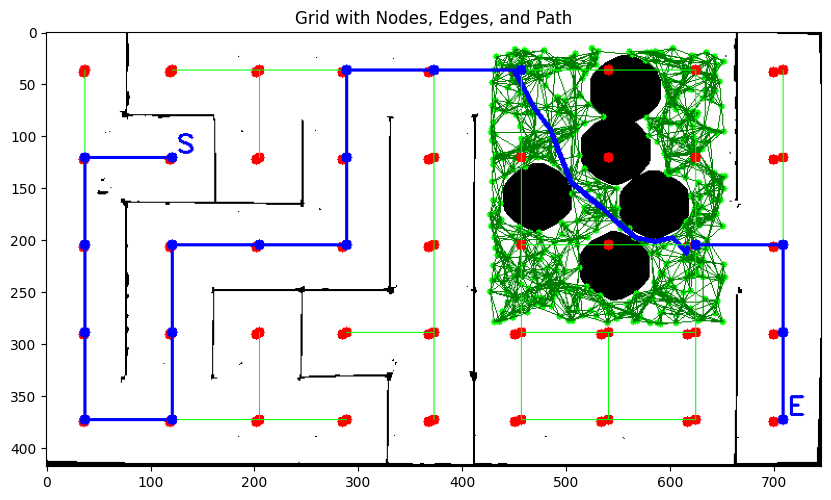

[(1, 1), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (3, 1), (2, 1), (2, 2), (2, 3), (1, 3), (0, 3), (0, 4), (0, 5)]
[(2, 7), (2, 8), (3, 8), (4, 8)]
Generated BFS Path 1 commands: rrflffflflffrfflffrff
Generated BFS 2 commands: frff


In [24]:
def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = prm_image.copy()
    
    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    # Add edges if any parallel lines in the path are all white
    for i in range(rows):
        for j in range(cols):
            x1 = start_x + j * cell_width
            y1 = start_y + i * cell_height

            # Check vertical edges
            if j < cols - 1:
                x2 = x1 + cell_width
                vertical_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if y1 + k < 0 or y1 + k >= result.shape[0]:  # Boundary check
                        continue
                    vertical_path = result[y1 + k, x1:x2]
                    if np.all(vertical_path == 255):
                        vertical_clear = True
                        break
                if vertical_clear:
                    graph.add_edge((i, j), (i, j + 1), 1)
                    cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

            # Check horizontal edges
            if i < rows - 1:
                y2 = y1 + cell_height
                horizontal_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if x1 + k < 0 or x1 + k >= result.shape[1]:  # Boundary check
                        continue
                    horizontal_path = result[y1:y2, x1 + k]
                    if np.all(horizontal_path == 255):
                        horizontal_clear = True
                        break
                if horizontal_clear:
                    graph.add_edge((i, j), (i + 1, j), 1)
                    cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)

    
    return grid_image, graph

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

# print(graph.nodes)

# Variable for path width
path_width = 3 

# Parameters for BFS
start_node = (start_position[0], start_position[1])
end_node = (end_position[0], end_position[1])

#################################################
# image is 'result_marked' from previous sections
#################################################

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_marked)
cv2.waitKey(0)
cv2.destroyAllWindows()

path_bfs_1 = None
path_bfs_2 = None

if 'selected_area' in globals():
    grid_image, graph = create_grid(result_marked, selected_area, rows, cols)
    
    # Find and highlight the paths
    path_bfs_1 = bfs_pathfinding(graph, start_node, prm_start_node)
    path_bfs_2 = bfs_pathfinding(graph, prm_end_node, end_node)
    
    # Draw the path and nodes
    for node in path_bfs_1:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    for node in path_bfs_2:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    
    # Draw edges on the path
    for i in range(len(path_bfs_1) - 1):
        x1, y1 = graph.nodes[path_bfs_1[i]].get_point()
        x2, y2 = graph.nodes[path_bfs_1[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for i in range(len(path_bfs_2) - 1):
        x1, y1 = graph.nodes[path_bfs_2[i]].get_point()
        x2, y2 = graph.nodes[path_bfs_2[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Highlight start and end nodes
    start_x, start_y = graph.nodes[start_node].get_point()
    end_x, end_y = graph.nodes[end_node].get_point()
    cv2.circle(grid_image, (start_x, start_y), node_radius, (0, 0, 255), -1)  
    cv2.circle(grid_image, (end_x, end_y), node_radius, (0, 0, 255), -1)  
    cv2.putText(grid_image, 'S', (start_x + node_radius, start_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(grid_image, 'E', (end_x + node_radius, end_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Display the final grid image with nodes, edges, and path
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes, Edges, and Path')
    plt.show()

    print(path_bfs_1)
    print(path_bfs_2)
else:
    print("No area selected. Please run the selection process again.")

# Getting the commands for BFS Paths 1
# Specify the direction at the start, matching the format in `generate_robot_commands`
start_node_with_direction = (start_node[0], start_node[1], 'E')  # Assuming the robot starts facing West
prm_start_node_with_direction = (prm_start_node[0], prm_start_node[1], 'E')  # Assuming robot reaches PRM facing East

bfs_path1_commands = path_command_string(path_bfs_1, start_node_with_direction, prm_start_node_with_direction)
print("Generated BFS Path 1 commands:", bfs_path1_commands)


# Getting the commands for BFS Paths 2
# Similarly, ensure the nodes are formatted with a direction
prm_end_node_with_direction = (prm_end_node[0], prm_end_node[1], 'E')  # Assuming the robot is facing East
end_node_with_direction = (end_node[0], end_node[1], 'N')  # Assuming it ends facing North

bfs_path2_commands = path_command_string(path_bfs_2, prm_end_node_with_direction, end_node_with_direction)
print("Generated BFS 2 commands:", bfs_path2_commands)

### 13 Seperate commands by maze section

In [25]:
def all_path_commands(BFS_Path1, PRM_Path, BFS_PATH2): 
        return [BFS_Path1, PRM_Path, BFS_PATH2]

all_path_commands(bfs_path1_commands, prm_path_string, bfs_path2_commands)

['rrflffflflffrfflffrff',
 'r60f24r3f20l2f75l8f75r15f164l28f113r3f57l2f74l28f58l25f52r62f59l129f18r80 ',
 'frff']